In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
df = pd.read_csv("../data/dataset.csv", encoding="ISO-8859-1", low_memory=False)


In [6]:
df.head()

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [7]:
# Convert date columns to datetime format
df['sampling_date'] = pd.to_datetime(df['sampling_date'], errors='coerce')
df['date'] = pd.to_datetime(df['date'], errors='coerce')

/var/folders/bn/z9sgk_zn55ng8xxd6g8b7g2r0000gn/T/ipykernel_45896/228574256.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['sampling_date'] = pd.to_datetime(df['sampling_date'], errors='coerce')


In [8]:
cols = ['so2', 'no2', 'rspm', 'spm', 'pm2_5']
df = df[cols]

In [9]:
# Handling missing values (filling with mean)
df.fillna(df.mean(), inplace=True)

In [10]:
df.head()

,so2,no2,rspm,spm,pm2_5
0,4.8,17.4,108.832784,220.78348,40.791467
1,3.1,7.0,108.832784,220.78348,40.791467
2,6.2,28.5,108.832784,220.78348,40.791467
3,6.3,14.7,108.832784,220.78348,40.791467
4,4.7,7.5,108.832784,220.78348,40.791467


In [11]:
# Define target (AQI) - Placeholder formula (Replace with actual AQI formula if available)
df['AQI'] = df['no2'] * 0.5 + df['so2'] * 0.3 + df['rspm'] * 0.2

In [12]:
df.head()

,so2,no2,rspm,spm,pm2_5,AQI
0,4.8,17.4,108.832784,220.78348,40.791467,31.906557
1,3.1,7.0,108.832784,220.78348,40.791467,26.196557
2,6.2,28.5,108.832784,220.78348,40.791467,37.876557
3,6.3,14.7,108.832784,220.78348,40.791467,31.006557
4,4.7,7.5,108.832784,220.78348,40.791467,26.926557


In [13]:
# Splitting data into training and testing sets
X = df.drop(columns=['AQI'])
y = df['AQI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# Train a RandomForest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [16]:

# Predictions
y_pred = model.predict(X_test)


In [17]:
print(y_pred)

[28.6        38.41165    25.55166261 ... 44.39565    52.25465667
 24.32873785]


In [18]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")


MAE: 0.09814287826287293, MSE: 0.5900891491215695, RMSE: 0.7681726037301575


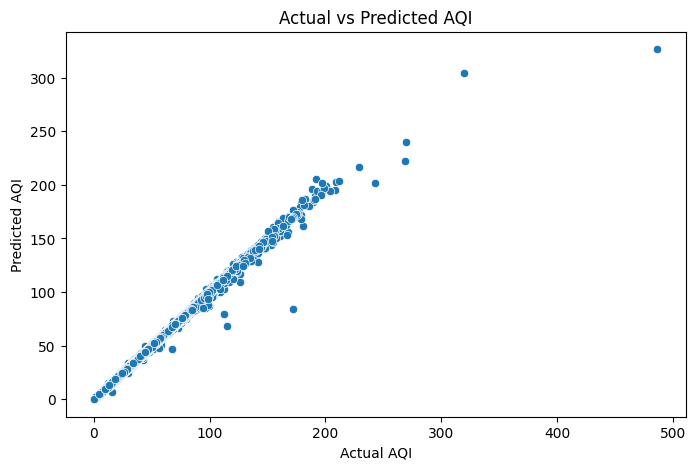

In [19]:
# Visualizing Predictions
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Actual vs Predicted AQI")
plt.show()


In [20]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.2f}")


R² Score: 1.00


In [22]:
import os
import pickle

# Get the absolute path of the model directory
model_dir = os.path.join(os.path.dirname(__file__), "../model")
model_dir = os.path.abspath(model_dir)  # Convert to absolute path

# Ensure the directory exists
os.makedirs(model_dir, exist_ok=True)

# Define the model file path
model_path = os.path.join(model_dir, "aqi_model.pkl")

# Save the trained model
with open(model_path, "wb") as f:
    pickle.dump(model, f)




Model saved as aqi_model.pkl
